# ***Imports***

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# df['date'] = pd.to_datetime(df['datetime'])  # Convert 'date' column to datetime format if needed

# # Extract the year from the 'date' column
# df['year'] = df['date'].dt.year

# # Filter the DataFrame for the first year
# first_year_data = df[df['year'] == df['year'].min() +4]

# # Drop the 'year' column if you don't need it anymore
# df = first_year_data.drop(columns=['year'])

# ***3m frequency data***

In [ ]:
df=pd.read_csv('/content/btc_3mSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


Streaming output truncated to the last 5000 lines.
holdings 0.5370797207400053
Buying 0.013060242275916052 BTC at 40874.97. Stop Loss: 40466.2203 signal :1 wallet balance 266384.6685142878 low risk True
holdings 0.550131398043909
Buying 0.013051677303903692 BTC at 40819.99. Stop Loss: 40411.7901 signal :1 wallet balance 265851.8990924233 low risk True
holdings 0.5631459819641186
Buying 0.013014583920209608 BTC at 40854.46. Stop Loss: 40445.9154 signal :1 wallet balance 265320.1952096436 low risk True
holdings 0.5761403382101004
Buying 0.01299435624598181 BTC at 40836.22. Stop Loss: 40427.8578 signal :1 wallet balance 264789.554734761 low risk True
holdings 0.5891151492635643
Buying 0.012974811053463965 BTC at 40815.94. Stop Loss: 40407.780600000006 signal :1 wallet balance 264259.9755409552 low risk True
holdings 0.6020693871390493
Buying 0.012954237875484949 BTC at 40799.0. Stop Loss: 40391.01 signal :1 wallet balance 263731.45550567075 low risk True
holdings 0.615009318355384
Buying 

# ***5m frequency data***

In [ ]:
df=pd.read_csv('/content/btc_5mSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


Streaming output truncated to the last 5000 lines.
holdings 0.007306519692588898
Buying 0.007306519692588898 BTC at 51094.91. Stop Loss: 50583.960900000005 signal :1 wallet balance 186289.65703943025 low risk True
holdings 0.014592735114465039
Buying 0.007286215421876141 BTC at 51134.82. Stop Loss: 50623.4718 signal :1 wallet balance 185917.07767799098 low risk True
holdings 0.021865688050498114
Buying 0.007272952936033076 BTC at 51125.61. Stop Loss: 50614.3539 signal :1 wallet balance 185545.2434753608 low risk True
Selling 0.021865688050498114 BTC at 51273.01 signal :-1 wallet balance 186666.36297530387 low risk True
holdings 0.007322401740248904
Buying 0.007322401740248904 BTC at 50985.01. Stop Loss: 50475.1599 signal :1 wallet balance 186293.03020175765 low risk True
holdings 0.01464299357906559
Buying 0.007320591838816686 BTC at 50895.62. Stop Loss: 50386.6638 signal :1 wallet balance 185920.44409377026 low risk True
holdings 0.021934866411404304
Buying 0.007291872832338715 BTC at

# ***15m frequency data***

In [ ]:
df=pd.read_csv('/content/btc_15mSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 8
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 * wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


Streaming output truncated to the last 5000 lines.
holdings 0.03073593319118377
Buying 0.007677591871866983 BTC at 33400.39. Stop Loss: 30728.3588 signal :1 wallet balance 127960.84677790808 low risk True
holdings 0.038393211044401986
Buying 0.007657277853218214 BTC at 33422.02. Stop Loss: 30748.2584 signal :1 wallet balance 127704.92503457995 low risk True
holdings 0.0460397340634454
Buying 0.007646523019043418 BTC at 33402.09. Stop Loss: 30729.922799999997 signal :1 wallet balance 127449.51513480839 low risk True
holdings 0.053672977346813096
Buying 0.007633243283367695 BTC at 33393.28. Stop Loss: 30721.8176 signal :1 wallet balance 127194.61605492269 low risk True
holdings 0.061348652817038885
Buying 0.00767567547022579 BTC at 33142.26. Stop Loss: 30490.879200000003 signal :1 wallet balance 126940.22677292096 low risk True
holdings 0.06897705216446882
Buying 0.00762839934742994 BTC at 33280.96. Stop Loss: 30618.4832 signal :1 wallet balance 126686.34626979052 low risk True
Selling 0

# ***30m frequency data***

In [ ]:
df=pd.read_csv('/content/btc_30mSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 8
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


holdings 0.014783047687894384
Buying 0.014783047687894384 BTC at 13529.01. Stop Loss: 12446.6892 signal :1 wallet balance 99799.9999039102 low risk True
Selling 0.014783047687894384 BTC at 13203.06 signal :-1 wallet balance 99995.18127342653 low risk True
holdings 0.014685186745602348
Buying 0.014685186745602348 BTC at 13618.51. Stop Loss: 12529.0292 signal :1 wallet balance 99795.19081542596 low risk True
holdings 0.02978215552989378
Buying 0.015096968784291431 BTC at 13220.56. Stop Loss: 12162.9152 signal :1 wallet balance 99595.6003356648 low risk True
holdings 0.04493421150607917
Buying 0.015152055976185392 BTC at 13146.15. Stop Loss: 12094.458 signal :1 wallet balance 99396.40903650511 low risk True
holdings 0.06002580576689155
Buying 0.01509159426081238 BTC at 13172.42. Stop Loss: 12118.626400000001 signal :1 wallet balance 99197.61612033674 low risk True
holdings 0.07531383737324251
Buying 0.015288031606350963 BTC at 12977.16. Stop Loss: 11938.9872 signal :1 wallet balance 98999

# ***1h frequency data***

In [ ]:
df=pd.read_csv('/content/btc_1hSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 8
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.92  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


Streaming output truncated to the last 5000 lines.
Buying 0.05542692854506104 BTC at 3527.63. Stop Loss: 3245.4196 signal :1 wallet balance 97567.32191548837 low risk True
holdings 0.3875991063184882
Buying 0.05537132604571842 BTC at 3524.11. Stop Loss: 3242.1812000000004 signal :1 wallet balance 97372.18691174377 low risk True
holdings 0.4428771005914055
Buying 0.055277994272917276 BTC at 3523.0. Stop Loss: 3241.1600000000003 signal :1 wallet balance 97177.44217861333 low risk True
holdings 0.49812294605963364
Buying 0.05524584546822816 BTC at 3518.0. Stop Loss: 3236.56 signal :1 wallet balance 96983.08693515812 low risk True
Selling 0.49812294605963364 BTC at 3545.05 signal :-1 wallet balance 98748.95444728767 low risk True
holdings 0.05621915994721758
Buying 0.05621915994721758 BTC at 3513.0. Stop Loss: 3231.96 signal :1 wallet balance 98551.45617296857 low risk True
holdings 0.11218028368049823
Buying 0.05596112373328066 BTC at 3522.14. Stop Loss: 3240.3688 signal :1 wallet balance

# ***2h frequency data***

In [ ]:
df=pd.read_csv('/content/btc_2hSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 5
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.95  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.005 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.95 # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.95  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


holdings 0.037285524342600275
Buying 0.037285524342600275 BTC at 13410.03. Stop Loss: 12739.5285 signal :1 wallet balance 99499.9997576441 low risk True
Selling 0.037285524342600275 BTC at 13022.0 signal :-1 wallet balance 99985.53161327753 low risk True
holdings 0.03708384298108136
Buying 0.03708384298108136 BTC at 13481.01. Stop Loss: 12806.959499999999 signal :1 wallet balance 99485.60371416617 low risk True
Selling 0.03708384298108136 BTC at 13690.03 signal :-1 wallet balance 99993.28239604748 low risk True
holdings 0.034965106813705106
Buying 0.034965106813705106 BTC at 14299.01. Stop Loss: 13584.0595 signal :1 wallet balance 99493.31575679405 low risk True
holdings 0.06917883481891904
Buying 0.034213728005213925 BTC at 14539.97. Stop Loss: 13812.971499999998 signal :1 wallet balance 98995.84895562084 low risk True
holdings 0.10327077981343338
Buying 0.03409194499451435 BTC at 14518.95. Stop Loss: 13793.0025 signal :1 wallet balance 98500.86948924509 low risk True
holdings 0.13758

# ***4h frequency data***

In [ ]:
df=pd.read_csv('/content/btc_4hSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.012 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


Streaming output truncated to the last 5000 lines.
holdings =  0.25132685170421026
Stop Loss hit. Selling 0.25132685170421026 BTC at 6493.41 wallet balance 99241.50174734727
holdings 0.075323402630357
Buying 0.075323402630357 BTC at 10540.31. Stop Loss: 10434.9069 signal :1 wallet balance 98447.56924376638 low risk True
holdings =  0.075323402630357
Stop Loss hit. Selling 0.075323402630357 BTC at 10434.9069 wallet balance 99233.56144800325
holdings 0.0764400839231646
Buying 0.0764400839231646 BTC at 10385.5. Stop Loss: 10281.645 signal :1 wallet balance 98439.69245955868 low risk True
holdings =  0.0764400839231646
Stop Loss hit. Selling 0.0764400839231646 BTC at 10281.645 wallet balance 99225.6217693663
holdings 0.07488726171272929
Buying 0.07488726171272929 BTC at 10600.0. Stop Loss: 10494.0 signal :1 wallet balance 98431.81630844418 low risk True
holdings 0.15163818842696186
Buying 0.07675092671423257 BTC at 10259.87. Stop Loss: 10157.2713 signal :1 wallet balance 97644.3612790956 l

# ***6h frequency data***

In [ ]:
df=pd.read_csv('/content/btc_6hSignals.csv')

In [ ]:
# Assuming you have a function to generate signals from your ML model
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)
# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


holdings 0.013628517946373144
Buying 0.013628517946373144 BTC at 14675.11. Stop Loss: 14528.358900000001 signal :1 wallet balance 99799.99991141463 low risk True
holdings =  0.013628517946373144
Stop Loss hit. Selling 0.013628517946373144 BTC at 14528.358900000001 wallet balance 99997.99982282927
holdings 0.013605216320168336
Buying 0.013605216320168336 BTC at 14699.95. Stop Loss: 14552.9505 signal :1 wallet balance 99798.0037347497 low risk True
holdings =  0.013605216320168336
Stop Loss hit. Selling 0.013605216320168336 BTC at 14552.9505 wallet balance 99995.99968596498
holdings 0.01341999413334438
Buying 0.01341999413334438 BTC at 14902.54. Stop Loss: 14753.5146 signal :1 wallet balance 99796.0075993631 low risk True
holdings =  0.01341999413334438
Stop Loss hit. Selling 0.01341999413334438 BTC at 14753.5146 wallet balance 99993.99959151135
holdings 0.013580605675880939
Buying 0.013580605675880939 BTC at 14726.0. Stop Loss: 14578.74 signal :1 wallet balance 99794.01150405439 low ris

holdings 0.013628517946373144
Buying 0.013628517946373144 BTC at 14675.11. Stop Loss: 14528.358900000001 signal :1 wallet balance 99799.99991141463 low risk True
holdings =  0.013628517946373144
Stop Loss hit. Selling 0.013628517946373144 BTC at 14528.358900000001 wallet balance 99997.99982282927
holdings 0.013605216320168336
Buying 0.013605216320168336 BTC at 14699.95. Stop Loss: 14552.9505 signal :1 wallet balance 99798.0037347497 low risk True
holdings =  0.013605216320168336
Stop Loss hit. Selling 0.013605216320168336 BTC at 14552.9505 wallet balance 99995.99968596498
holdings 0.01341999413334438
Buying 0.01341999413334438 BTC at 14902.54. Stop Loss: 14753.5146 signal :1 wallet balance 99796.0075993631 low risk True
holdings =  0.01341999413334438
Stop Loss hit. Selling 0.01341999413334438 BTC at 14753.5146 wallet balance 99993.99959151135
holdings 0.013580605675880939
Buying 0.013580605675880939 BTC at 14726.0. Stop Loss: 14578.74 signal :1 wallet balance 99794.01150405439 low ris

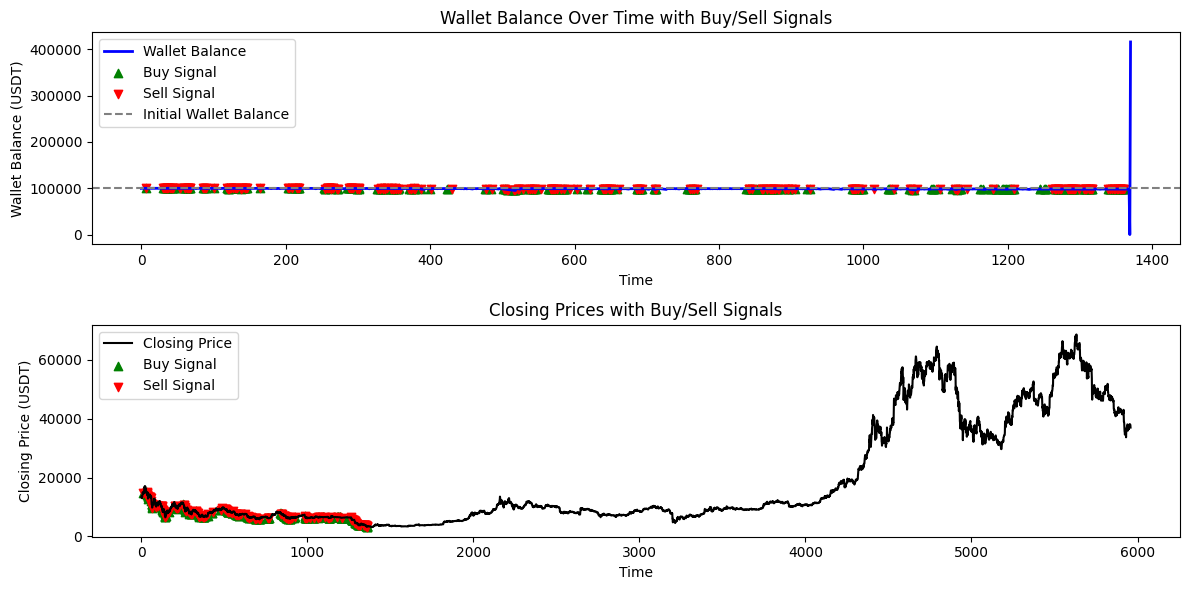

In [ ]:
# Assuming you have a function to generate signals from your ML model
import matplotlib.pyplot as plt
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0
    wallet_balance_history = []  # To store wallet balance over time
    buy_points = []
    sell_points = []

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs
                wallet_balance_history.append(wallet_balance)

                highest_price_reached = row['close']
                buy_points.append(index)
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs
                wallet_balance_history.append(wallet_balance)

                highest_price_reached = row['close']
                buy_points.append(index)
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs
                wallet_balance_history.append(wallet_balance)

                highest_price_reached = row['close']
                buy_points.append(index)
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs
              wallet_balance_history.append(wallet_balance)
              sell_points.append(index)


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs
            wallet_balance_history.append(wallet_balance)

            sell_points.append(index)
            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs
              wallet_balance_history.append(wallet_balance)

              sell_points.append(index)
              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs
                wallet_balance_history.append(wallet_balance)

                sell_points.append(index)
                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs

        sell_points.append(index)
        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0
        wallet_balance_history.append(wallet_balance)

    print("Final Wallet Balance:", wallet_balance)
    plt.figure(figsize=(12, 6))

    # Plot wallet balance over time
    plt.subplot(2, 1, 1)
    plt.plot(wallet_balance_history, label='Wallet Balance', linewidth=2, color='blue')

    # Ensure buy_points and sell_points are within the valid range
    buy_points = [idx for idx in buy_points if idx < len(wallet_balance_history)]
    sell_points = [idx for idx in sell_points if idx < len(wallet_balance_history)]

    plt.scatter(buy_points, [wallet_balance_history[i] for i in buy_points], color='green', marker='^', label='Buy Signal')
    plt.scatter(sell_points, [wallet_balance_history[i] for i in sell_points], color='red', marker='v', label='Sell Signal')
    plt.axhline(y=initial_wallet_balance, color='gray', linestyle='--', label='Initial Wallet Balance')
    plt.title('Wallet Balance Over Time with Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Wallet Balance (USDT)')
    plt.legend()

    # Plotting closing prices
    plt.subplot(2, 1, 2)
    plt.plot(data['close'], label='Closing Price', color='black')

    # Ensure buy_points and sell_points are within the valid range
    buy_points = [idx for idx in buy_points if idx < len(data)]
    sell_points = [idx for idx in sell_points if idx < len(data)]

    plt.scatter(buy_points, data['close'].iloc[buy_points], color='green', marker='^', label='Buy Signal')
    plt.scatter(sell_points, data['close'].iloc[sell_points], color='red', marker='v', label='Sell Signal')
    plt.title('Closing Prices with Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Closing Price (USDT)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)


holdings 0.013628517946373144
Buying 0.013628517946373144 BTC at 14675.11. Stop Loss: 14528.358900000001 signal :1 wallet balance 99799.99991141463 low risk True
holdings =  0.013628517946373144
Stop Loss hit. Selling 0.013628517946373144 BTC at 14528.358900000001 wallet balance 99997.99982282927
holdings 0.013605216320168336
Buying 0.013605216320168336 BTC at 14699.95. Stop Loss: 14552.9505 signal :1 wallet balance 99798.0037347497 low risk True
holdings =  0.013605216320168336
Stop Loss hit. Selling 0.013605216320168336 BTC at 14552.9505 wallet balance 99995.99968596498
holdings 0.01341999413334438
Buying 0.01341999413334438 BTC at 14902.54. Stop Loss: 14753.5146 signal :1 wallet balance 99796.0075993631 low risk True
holdings =  0.01341999413334438
Stop Loss hit. Selling 0.01341999413334438 BTC at 14753.5146 wallet balance 99993.99959151135
holdings 0.013580605675880939
Buying 0.013580605675880939 BTC at 14726.0. Stop Loss: 14578.74 signal :1 wallet balance 99794.01150405439 low ris

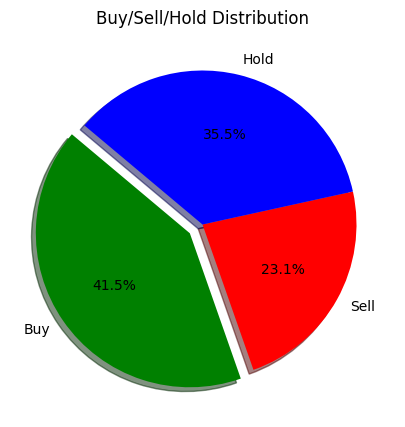

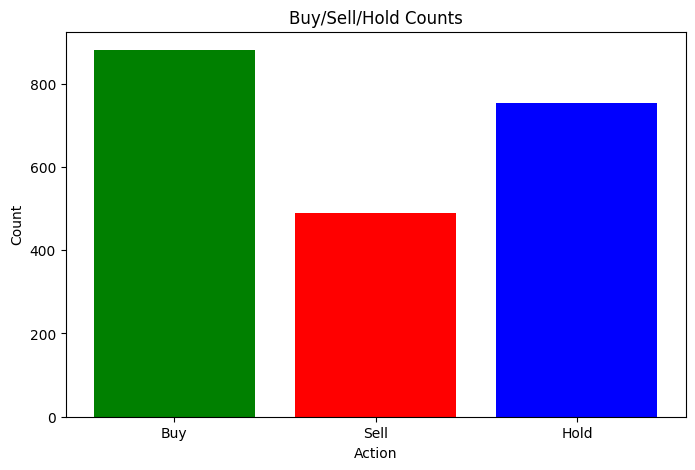

In [ ]:
# Assuming you have a function to generate signals from your ML model
import matplotlib.pyplot as plt
def generate_signals(row):
    # Replace this with your actual ML model's signal generation logic
    # For demonstration purposes, generating random signals (1: Buy, -1: Sell, 0: Hold)

    return row['FinalSig']


def calculate_transaction_costs(trades):
    return trades * 0.0015  # 0.15%

def calculate_slippage(trades):
    return trades * 0.005  # 0.5%

def dynamic_stoploss(entry_price, current_price, highest_price):
    stop_loss_percent = 1
    take_profit_percent = 10

    if current_price < entry_price * (1 - stop_loss_percent / 100):
        return entry_price * (1 - stop_loss_percent / 100)
    elif current_price > entry_price * (1 + take_profit_percent / 100):
        highest_price = max(highest_price, current_price)
        return highest_price * (1 - stop_loss_percent / 100)
    else:
        return highest_price * (1 - stop_loss_percent / 100)

def apply_risk_management(data, initial_wallet_balance):
    wallet_balance = initial_wallet_balance
    holdings = 0
    highest_price_reached = 0

    low_risk_mode_threshold = 0.85
    low_risk_mode = True

    buy_count = 0
    sell_count = 0
    hold_count = 0

    for index, row in data.iterrows():
        signal = generate_signals(row)

        # Check if the wallet balance is in low-risk or high-risk mode
        if wallet_balance >= low_risk_mode_threshold * initial_wallet_balance:
            low_risk_mode = True
        else:
            low_risk_mode = False

        # Buy signal Buy signal Buy signal

        if signal > 0 and wallet_balance > 0 and holdings / initial_wallet_balance < 0.3:
          if wallet_balance >= row['close']:
            if low_risk_mode:
              if signal==2:
                buy_count += 1
                btc_to_buy = (wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                buy_count += 1
                btc_to_buy = (0.002 * wallet_balance) / row['close']
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")

            else:
              if signal==2:
                buy_count += 1
                btc_to_buy = (0.5 *wallet_balance/row['close'])
                stop_loss_price = row['close'] * 0.99  # 4% below entry

                wallet_balance -= btc_to_buy * row['close']
                holdings += btc_to_buy
                transaction_costs = calculate_transaction_costs(btc_to_buy)
                slippage_costs = calculate_slippage(btc_to_buy)
                wallet_balance -= transaction_costs + slippage_costs

                highest_price_reached = row['close']
                print("holdings",holdings)
                print(f"Buying {btc_to_buy} BTC at {row['close']}. Stop Loss: {stop_loss_price} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              else:
                hold_count += 1
                continue
          else:
            print("Low Balance........ Can't buy BTC......")
            if holdings > 0:
              wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
              holdings = 0
            break



        # Sell signal
        elif signal < 0 and holdings > 0:
          if low_risk_mode :
            sell_count += 1
            wallet_balance += holdings * row['close']
            transaction_costs = calculate_transaction_costs(holdings)
            slippage_costs = calculate_slippage(holdings)
            wallet_balance -= transaction_costs + slippage_costs


            print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
            holdings = 0
          else:
            if signal==-2:
              sell_count += 1

              wallet_balance += holdings * row['close']
              transaction_costs = calculate_transaction_costs(holdings)
              slippage_costs = calculate_slippage(holdings)
              wallet_balance -= transaction_costs + slippage_costs


              print(f"Selling {holdings} BTC at {row['close']} signal :{signal} wallet balance {wallet_balance} low risk {low_risk_mode}")
              holdings = 0
            else:
              hold_count += 1
              continue


        # Update dynamic stop-loss in case of an open position
        if holdings > 0:
            stop_loss_price = dynamic_stoploss(row['close'], row['close'], highest_price_reached)

            # Check if the current price hits the stop-loss
            if row['low'] <= stop_loss_price:
                print("holdings = ",holdings)
                sell_count += 1
                wallet_balance += holdings * stop_loss_price
                transaction_costs = calculate_transaction_costs(holdings)
                slippage_costs = calculate_slippage(holdings)
                wallet_balance -= transaction_costs + slippage_costs


                print(f"Stop Loss hit. Selling {holdings} BTC at {stop_loss_price} wallet balance {wallet_balance}")
                holdings = 0

    if holdings > 0:
        sell_count += 1
        wallet_balance += holdings * data['close'].iloc[-1]  # Sell at the last closing price
        transaction_costs = calculate_transaction_costs(holdings)
        slippage_costs = calculate_slippage(holdings)
        wallet_balance -= transaction_costs + slippage_costs


        print(f"Selling remaining {holdings} BTC at {data['close'].iloc[-1]}. Final Wallet Balance: {wallet_balance}")
        holdings = 0

    print("Final Wallet Balance:", wallet_balance)

    labels = ['Buy', 'Sell', 'Hold']
    sizes = [buy_count, sell_count, hold_count]
    colors = ['green', 'red', 'blue']
    explode = (0.1, 0, 0)  # explode 1st slice

    plt.figure(figsize=(10, 5))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Buy/Sell/Hold Distribution')
    plt.show()

    # Plotting the bar graph for various indexes
    index_counts = {'Buy': buy_count, 'Sell': sell_count, 'Hold': hold_count}
    plt.figure(figsize=(8, 5))
    plt.bar(index_counts.keys(), index_counts.values(), color=['green', 'red', 'blue'])
    plt.title('Buy/Sell/Hold Counts')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()

# Example usage:
# Load historical BTC/USDT data (replace 'your_data.csv' with your actual data)
#data = pd.read_csv('your_data.csv')

# Set initial wallet balance
initial_wallet_balance = 100000

# Apply risk management strategy
apply_risk_management(df, initial_wallet_balance)
